## **9. Supervised ML**

### **9-1. 의사결정나무와 앙상블**

#### 9-1-1. 의사결정나무
- greedy heuristic 방법: 각 단계에서 불순도를 최대로 줄이는 피쳐 선택
- 불순도 for 분류결정트리: 엔트로피(0 ~ 1), 지니 불순도(0 ~ 1), log loss  
  불순도 for 회귀결정트리: squared error, friedman MSE, absolute error, poisson
- 장점: 계산 비용 낮음, 해석/이해 쉬움, 정규화/표준화 전처리 불필요, 이상치/결측치 강함  
  단점: 모든 특성 사용하기에 과적합 위험 -> 트리크기 제한, 조기 종료 등 방법 강구  
        모델 밖의 데이터 범위에서는 새로운 데이터 예측 불가 (따라서, 시계열에 부적합)
- 과적합 제어 전략  
  1) 사전 가지치기: 최대 깊이, 리프 최대 개수, 노드별 데이터 최소 개수 등 지정
  2) 사후 가지치기 (sklearn 지원 X): 데이터가 적은 노드를 삭제 및 병합

In [1]:
from collections import Counter
import numpy as np

# 엔트로피 계산 함수 정의하기
def entropy(data):
    if type(data[0]) == float: #클래스별 확률을 입력하는 경우
        ratio = np.array(data)
        value = -(ratio * np.log2(ratio)).sum()
    else: 
        counts = Counter(data) #범주형 데이터를 입력하는 경우
        m = np.array(list(counts.keys()))
        freq = np.array(list(counts.values()))
        total = freq.sum()
        ratio = freq/total
        value = -(ratio * np.log2(ratio)).sum()
    return value

# 지니 불순도 계산 함수 정의하기
def gini(data):
    if type(data[0]) == float:
        ratio = np.array(data)
        value = 1-(ratio**2).sum()
    else: 
        counts = Counter(data)
        m = np.array(list(counts.keys()))
        freq = np.array(list(counts.values()))
        total = freq.sum()
        ratio = freq/total
        value = 1-(ratio**2).sum()
    return value

In [2]:
print('[binary class data] ')
bi_result = ['A', 'A', 'A', 'B', 'B']
e1 = entropy(bi_result)
e2 = entropy([3/5, 2/5])
print("entropy: {:.2f} ({:.2f})".format(e1, e2))

g1 = gini(bi_result)
g2 = gini([3/5, 2/5])
print("gini: {:.2f} ({:.2f})".format(g1, g2))

[binary class data] 
entropy: 0.97 (0.97)
gini: 0.48 (0.48)


In [3]:
print('[multi class data]')
multi_result = ['A', 'B', 'C', 'C', 'D', 'D', 'D', 'D']
e1 = entropy(multi_result)
e2 = entropy([1/8, 1/8, 2/8, 4/8])
print("entropy: {:.2f} ({:.2f})".format(e1, e2))

g1 = gini(multi_result)
g2 = gini([1/8, 1/8, 2/8, 4/8])
print("gini: {:.2f} ({:.2f})".format(g1, g2))

[multi class data]
entropy: 1.75 (1.75)
gini: 0.66 (0.66)


In [4]:
# 결정 트리 적합하기 (분류)
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# 시각화 셋팅
plt.rcParams["figure.figsize"] = (15, 15)
# plt.rcParams["font.family"] = 'D2Coding' #PC에 설치된 글꼴로 지정
plt.rcParams["font.size"] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=43)

# 결정트리 분류기 적합: max_depth를 3으로 지정함으로써 사전 가지치기를 통해 과적합을 제어한다.
tree=DecisionTreeClassifier(max_depth=3, criterion='gini') # 3층 깊이의 결정 트리 생성
tree.fit(X_train, y_train)

# 결정트리로 분류 예측 및 성능 확인
y_pred=tree.predict(X_test) #예측값
print("Tree Score: {:.3f}".format(tree.score(X_test, y_test))) #mean accuracy

Tree Score: 0.930


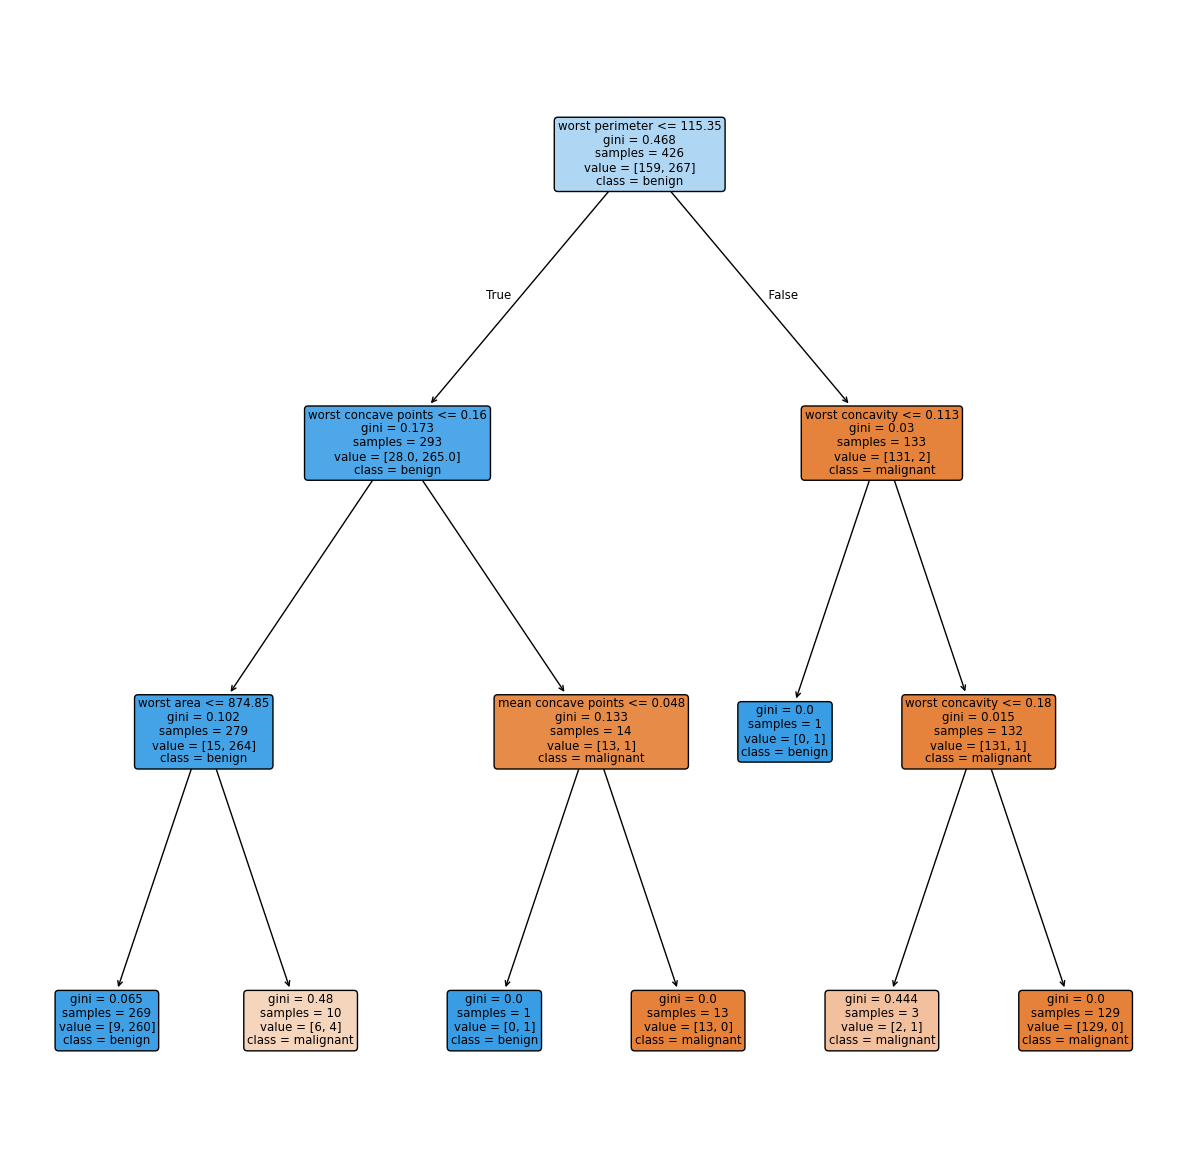

In [5]:
# 결정트리 시각화
plot_tree(tree, class_names=cancer.target_names, feature_names=cancer.feature_names, impurity=True, filled=True, rounded=True)
plt.show()

In [6]:
# 트리의 분기를 텍스트로도 확인할 수 있다.
print(export_text(tree))

|--- feature_22 <= 115.35
|   |--- feature_27 <= 0.16
|   |   |--- feature_23 <= 874.85
|   |   |   |--- class: 1
|   |   |--- feature_23 >  874.85
|   |   |   |--- class: 0
|   |--- feature_27 >  0.16
|   |   |--- feature_7 <= 0.05
|   |   |   |--- class: 1
|   |   |--- feature_7 >  0.05
|   |   |   |--- class: 0
|--- feature_22 >  115.35
|   |--- feature_26 <= 0.11
|   |   |--- class: 1
|   |--- feature_26 >  0.11
|   |   |--- feature_26 <= 0.18
|   |   |   |--- class: 0
|   |   |--- feature_26 >  0.18
|   |   |   |--- class: 0



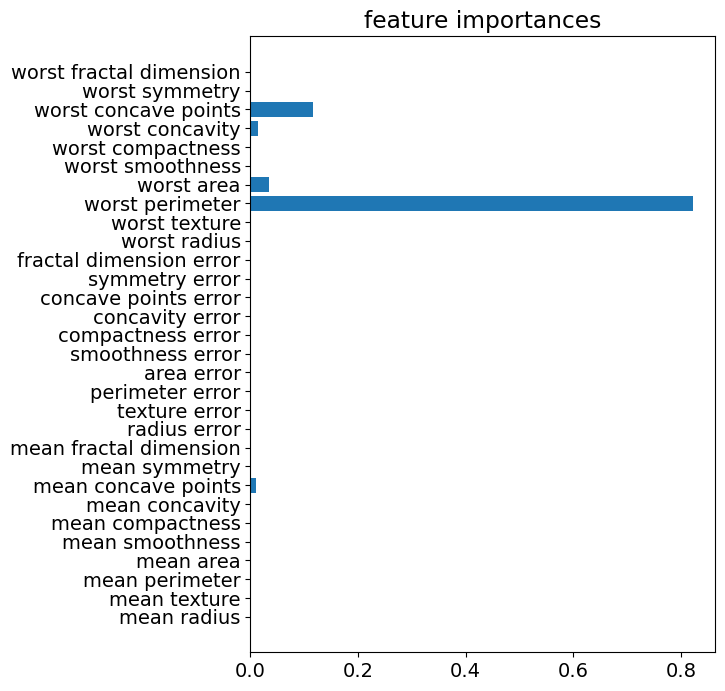

In [15]:
# feature 중요도 확인
plt.subplots(1,1, figsize=(6,8))
fi = tree.feature_importances_
fn = cancer.feature_names
plt.title("feature importances")
plt.barh(fn, fi)
plt.show()

## 회귀 결정 트리는 from sklearn.tree import DecisionTreeRegresssor로 동일하게 진행

#### 9-1-2. 앙상블
- 일반적으로 의사결정나무들을 합하여 활용하지만, 다른 지도 학습 알고리즘도 활용 가능
- hard voting (다수결 투표) / soft voting (평균 또는 가중치 합) / stacking

#### 배깅
- 분류: 가장 빈도 높은 클래스로 최종값 예측 / 회귀: 예측 결과들을 평균
- Robust bagging: 이상치 영향을 줄이기 위하여 평균 대신 중위수 사용
- OOB(out-of-bag): 36.8% 한 번도 훈련에 포함되지 않은 데이터. 성능 검증에 활용.

In [44]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# 데이터 불러오기
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
print("data shape: ", X.shape)
print("train size: {}, test size: {}".format(len(X_train), len(X_test)))

data shape:  (569, 30)
train size: 426, test size: 143


In [17]:
# 결정 트리를 배깅하는 앙상블 기법
ESTIMATOR = DecisionTreeClassifier(max_depth=3, min_samples_leaf=4)
bagging = BaggingClassifier(ESTIMATOR, n_estimators=50, oob_score=True, n_jobs=-1, random_state=0, max_samples = 1.0, max_features = 1.0)
bagging.fit(X_train, y_train)
bagging_pred = bagging.predict(X_test) #test set에 대한 예측값
bagging_prob = bagging.predict_proba(X_test)[:, 1] #test set의 1에 대한 예측 확률

# 적합 결과 확인
print('train set accuracy: {:.3f}'.format(bagging.score(X_train, y_train)))
print('test set accuracy: {:.3f}'.format(bagging.score(X_test, y_test)))
print('OOB accuracy: {:.3f}'.format(bagging.oob_score_))

train set accuracy: 0.977
test set accuracy: 0.923
OOB accuracy: 0.955


In [21]:
print("첫번째 estimator의 bootstrap 샘플 수 {}, 원본 훈련샘플 수 {} :".format(len(bagging.estimators_samples_[0]), len(X_train)))
# 각 estimator들이 모델 훈련을 위해 사용한 샘플들의 인덱스 리스트를 반환한다. 
# 그 중, 첫번째 estimator의 샘플의 개수와 인덱스 일부를 조회해 보면, 
# 원본 X_train과 부트스트랩 샘플의 개수가 일치하는 것을 볼 수 있다. 
# 이는 BaggingClassifier의 파라미터 max_samples=1.0 즉 100% 뽑기로 설정했기 때문이다. 
# 0.5로 하면, 원본 데이터 개수의 반만한 부트스트랩 샘플들로 배깅을 하게 된다. 

첫번째 estimator의 bootstrap 샘플 수 426, 원본 훈련샘플 수 426 :


In [20]:
print("첫번째 estimator가 bootstraping할 때 선택한 feature 수: {}, 원본 훈련샘플 feature 수: {}\n".format(len(bagging.estimators_features_[0]), X_train.shape[1]))
# 각 estimator들이 모델 훈련을 위해 사용한 샘플들의 feature 리스트를 반환한다. 
# 그 중, 첫번째 estimator의 feature의 개수를 조회해 보면, 
# 원본 X_train과 부트스트랩 샘플의 feature의 개수와 일치하는 것을 볼 수 있다. 
# 이는 BaggingClassifier의 파라미터 max_features=1.0 즉 100% 뽑기로 설정했기 때문이다. 
# 0.5로 하면, 원본 데이터 feature에서 반개만 랜덤으로 선택하여 부트스트랩 샘플을 생성한다.

첫번째 estimator가 bootstraping할 때 선택한 feature 수: 30, 원본 훈련샘플 feature 수: 30



#### 부스팅
- 잔차가 큰 데이터 가중치 높여 오차를 줄이는 방향으로, 모델을 **순차적으로** 생성
- Adaptive (Ada) / Gradient (GBM) / Stochastic gradient (XGB)

C:\Users\sunwa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


train set accuracy: 1.000
test set accuracy: 0.944


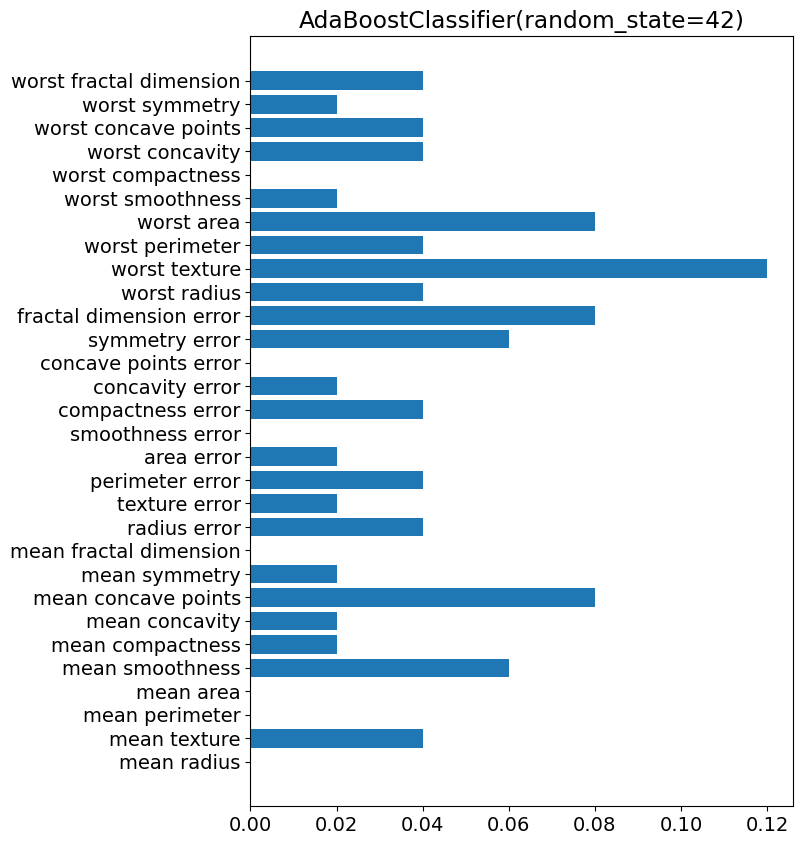

In [22]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(random_state=42, n_estimators=50)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test) #test set에 대한 예측값
ada_prob = ada.predict_proba(X_test)[:, 1] #test set의 1에 대한 예측 확률

# 적합 결과 확인
print('train set accuracy: {:.3f}'.format(ada.score(X_train, y_train)))
print('test set accuracy: {:.3f}'.format(ada.score(X_test, y_test)))

# 특징 중요도 확인
fi = ada.feature_importances_
fn = cancer.feature_names
fig, ax = plt.subplots(figsize=(7,10))
plt.title(ada)
plt.barh(fn, fi)
plt.show()

train set accuracy: 1.000
test set accuracy: 0.951


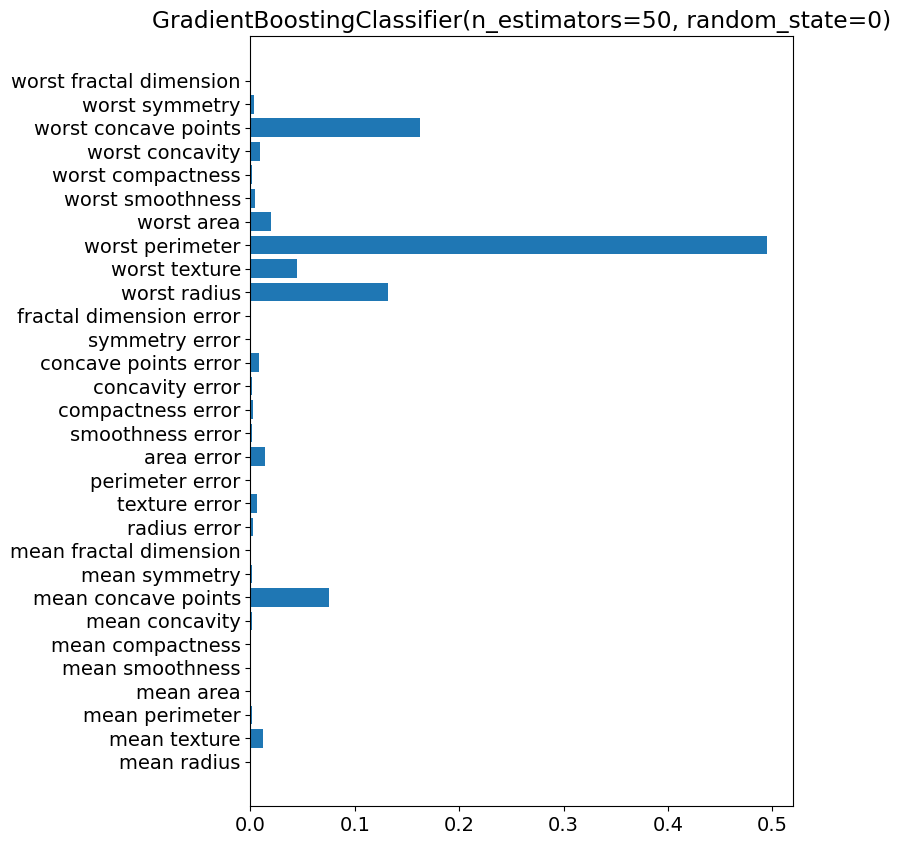

In [25]:
# Gradient Boosting (1) - GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=0, n_estimators=50)
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test) #test set에 대한 예측값
gbc_prob = gbc.predict_proba(X_test)[:, 1] #test set의 1에 대한 예측 확률

# 적합 결과 확인
print('train set accuracy: {:.3f}'.format(gbc.score(X_train, y_train)))
print('test set accuracy: {:.3f}'.format(gbc.score(X_test, y_test)))

# 특징 중요도 확인
fi = gbc.feature_importances_
fn = cancer.feature_names
fig, ax = plt.subplots(figsize=(7,10))
plt.title(gbc)
plt.barh(fn, fi)
plt.show()

In [27]:
!pip install lightgbm

[LightGBM] [Info] Number of positive: 267, number of negative: 159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4272
[LightGBM] [Info] Number of data points in the train set: 426, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626761 -> initscore=0.518344
[LightGBM] [Info] Start training from score 0.518344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

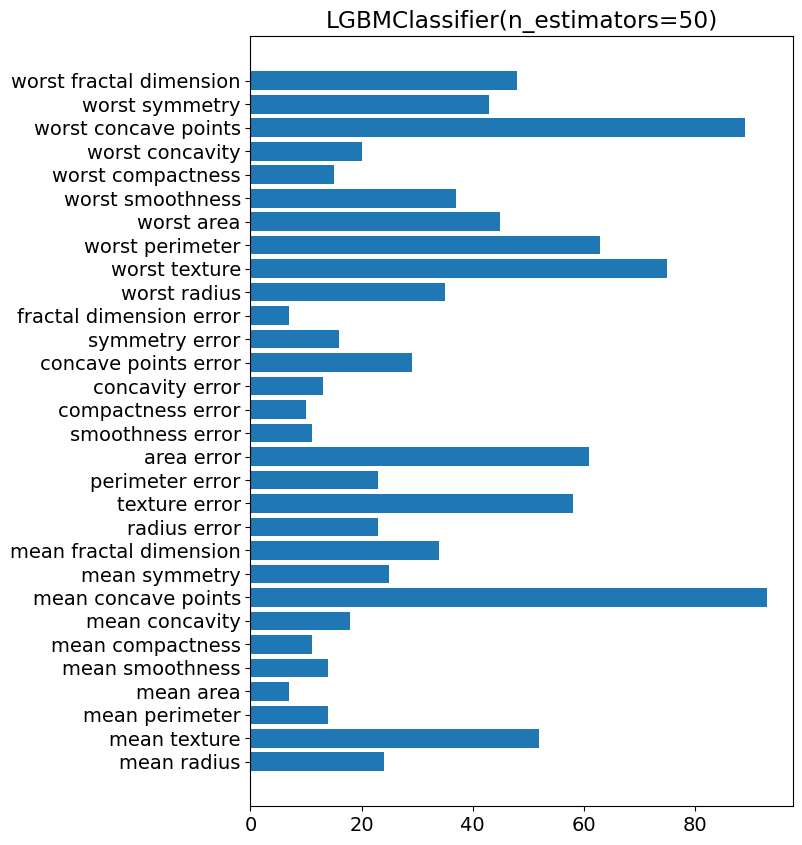

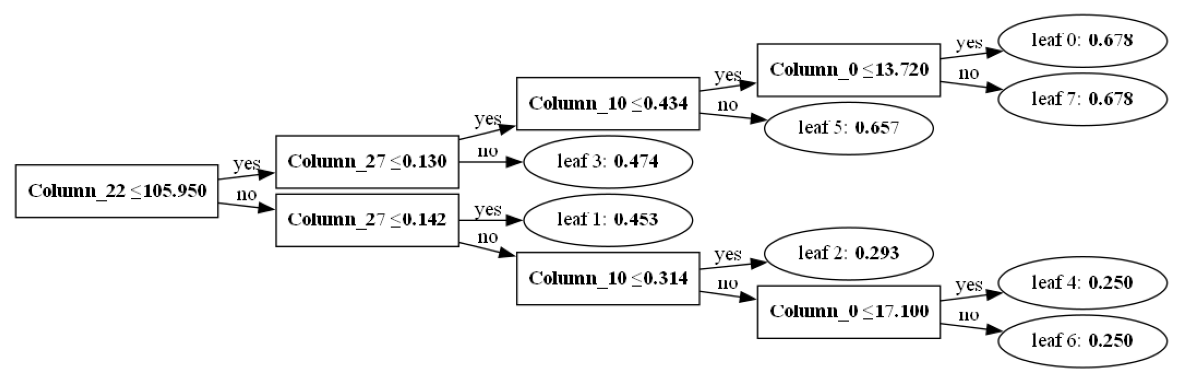

In [46]:
# Gradient Boosting (2) - LightGBM
from lightgbm import LGBMClassifier, plot_importance, plot_tree, create_tree_digraph
lgbm = LGBMClassifier(n_estimators=50)
lgbm.fit(X_train, y_train, eval_metric='logloss', eval_set=[(X_test, y_test)]) # early_stopping_rounds=100, verbose=False
lgbm_pred = lgbm.predict(X_test) #test set에 대한 예측값
lgbm_prob = lgbm.predict_proba(X_test)[:, 1] #test set의 1에 대한 예측 확률

# 적합 결과 확인
print('train set accuracy: {:.3f}'.format(lgbm.score(X_train, y_train)))
print('test set accuracy: {:.3f}'.format(lgbm.score(X_test, y_test)))

# 특징 중요도 확인: plot_importance(lgbm)으로도 plotting 가능하다. 
fi = lgbm.feature_importances_
fn = cancer.feature_names
fig, ax = plt.subplots(figsize=(7,10))
plt.title(lgbm)
plt.barh(fn, fi)
plt.show()

# 트리 시각화
fig, ax = plt.subplots(figsize=(15,10))
plot_tree(lgbm, ax=ax)
plt.show()

In [35]:
!pip install xgboost

train set accuracy: 1.000
test set accuracy: 0.951


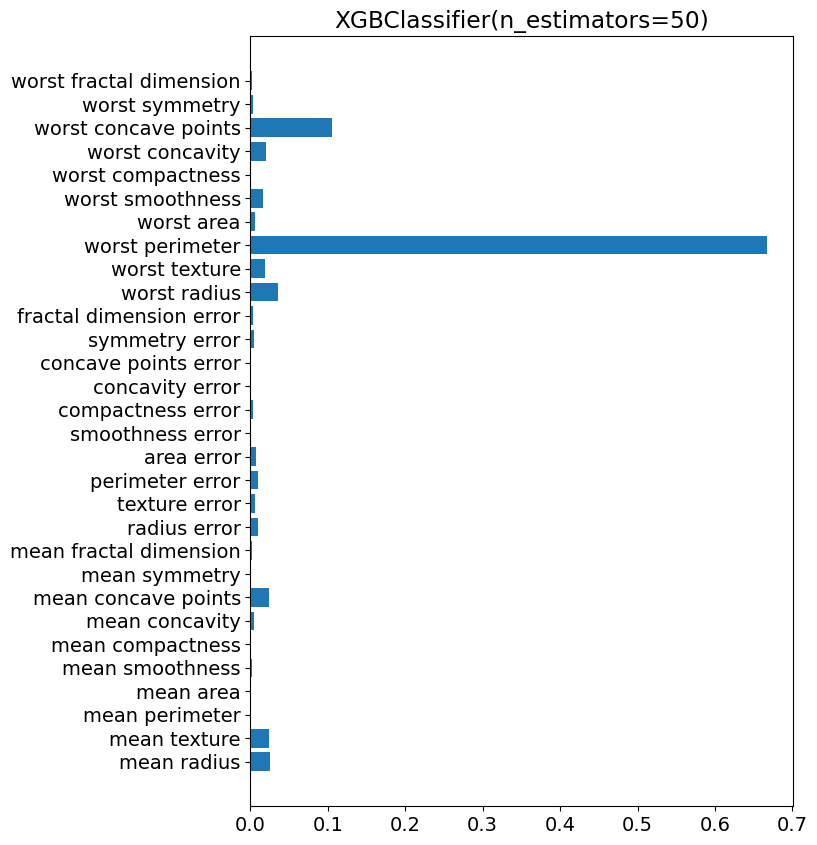

In [40]:
# Stochastic gradient boosting - xgboost
from xgboost import plot_importance, XGBClassifier
xg = XGBClassifier(objective='binary:logistic', n_estimators=50, eval_metric='logloss')
xg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
xg_pred = xg.predict(X_test)
xg_prob = xg.predict_proba(X_test)[:, 1] #test set의 1에 대한 예측 확률

# 적합 결과 확인
print('train set accuracy: {:.3f}'.format(xg.score(X_train, y_train)))
print('test set accuracy: {:.3f}'.format(xg.score(X_test, y_test)))

# 특징 중요도 확인
fi = xg.feature_importances_
fn = cancer.feature_names
fig, ax = plt.subplots(figsize=(7,10))
plt.title('XGBClassifier(n_estimators=50)')
plt.barh(fn, fi)
plt.show()

#### 랜덤포레스트와 Extra-trees
랜덤포레스트
- 무작위성 트리 생성: 부트스크랩 샘플링 + 특성 무작위 선택 (불순도 기준값)
- 장점: 트리 병렬 실행하여 계산비용 낮음, 매개변수 튜닝 및 표준화/정규화 필요 없음  
  단점: 단일 트리보다 예측 성능은 뛰어나지만 직관적 해석 불가, 고차원 희소 데이터 작동 X

Extra-trees (ERT, Extremely randomized tree)
- RF와 유사, 다만 가지 분할 시 데이터를 가장 잘 분할할 수 있는 임계값 대신 랜덤 임곗값 사용

train set accuracy: 1.000
test set accuracy: 0.944


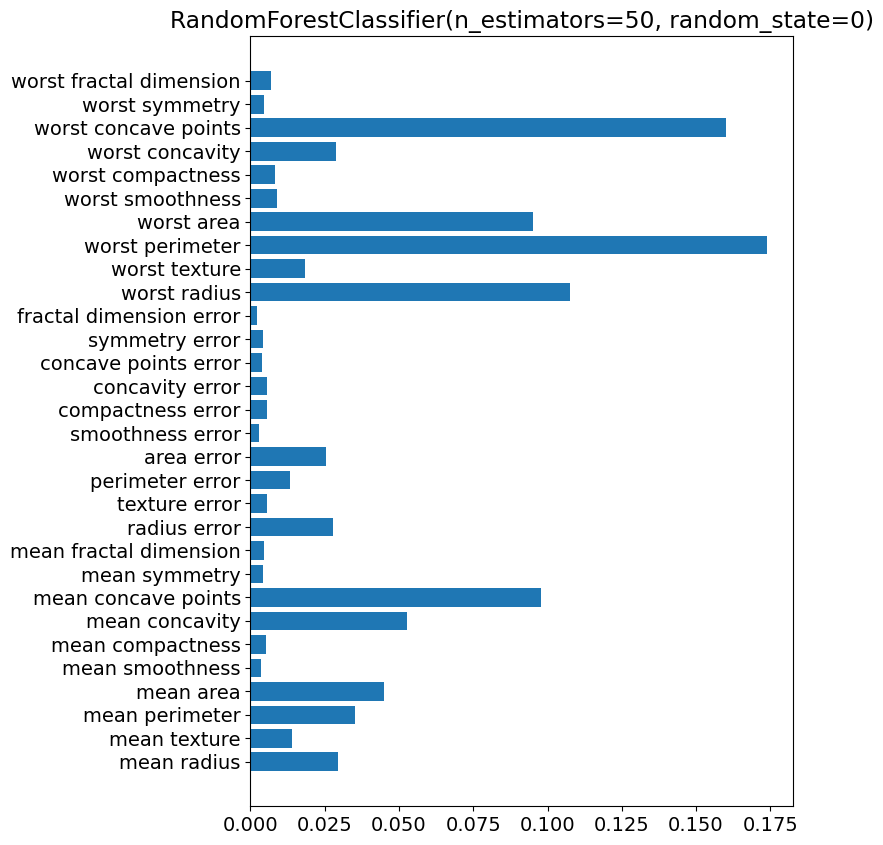

In [47]:
# Random forest
# 랜덤포레스트에서는 단일 트리의 경우보다 훨씬 많은 특성이 0 이상의 중요도 값을 갖는다.

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test) #test set에 대한 예측값
rf_prob = rf.predict_proba(X_test)[:, 1] #test set의 1에 대한 예측 확률

# 적합 결과 확인
print('train set accuracy: {:.3f}'.format(rf.score(X_train, y_train)))
print('test set accuracy: {:.3f}'.format(rf.score(X_test, y_test)))

# 특징 중요도 확인
fi = rf.feature_importances_
fn = cancer.feature_names
fig, ax = plt.subplots(figsize=(7,10))
plt.title(rf)
plt.barh(fn, fi)
plt.show()

train set accuracy: 1.000
test set accuracy: 0.944


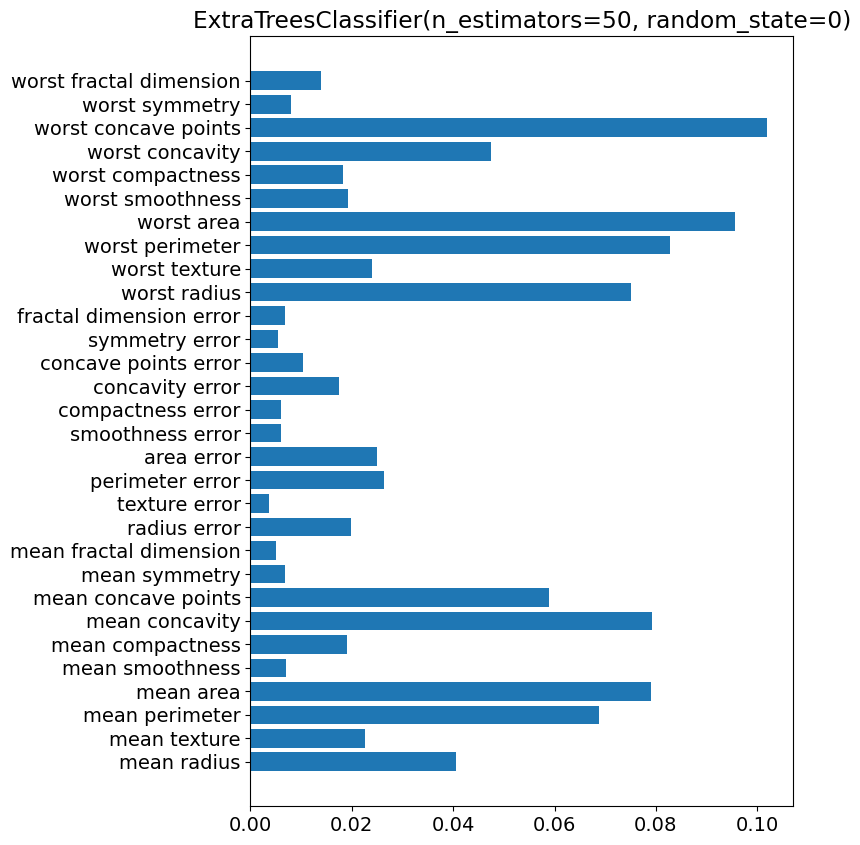

In [48]:
# Extra-trees
from sklearn.ensemble import ExtraTreesClassifier
xtree = ExtraTreesClassifier(n_estimators=50, random_state=0)
xtree.fit(X_train, y_train)
xtree_pred = xtree.predict(X_test) #test set에 대한 예측값
xtree_prob = xtree.predict_proba(X_test)[:, 1] #test set의 1에 대한 예측 확률

# 적합 결과 확인
print('train set accuracy: {:.3f}'.format(xtree.score(X_train, y_train)))
print('test set accuracy: {:.3f}'.format(xtree.score(X_test, y_test)))

# 특징 중요도 확인
fi = xtree.feature_importances_
fn = cancer.feature_names
fig, ax = plt.subplots(figsize=(7,10))
plt.title(xtree)
plt.barh(fn, fi)
plt.show()

#### 스태킹
- 각 앙상블 모델로부터 얻은 예측 확률 or 값을 데이터로, 한번 더 모델링하여 성능 개선

In [51]:
titles = ['bagging', 'adaboost', 'gboost', 'lgbm', 'xgboost', 'random forest', 'xtree']
preds = [bagging_pred, ada_pred, gbc_pred, lgbm_pred, xg_pred, rf_pred, xtree_pred]
probs = [bagging_prob, ada_prob, gbc_prob, lgbm_prob, xg_prob, rf_prob, xtree_prob]

from pandas import DataFrame
import numpy as np
# 각 앙상블들의 예측 확률을 feature로, 실제 y_test값을 target으로 하는 모델 생성
probs_df = DataFrame(probs).T
meta_learner = RandomForestClassifier(n_estimators=30, random_state=0, max_depth=3)
meta_learner.fit(probs_df, y_test)
meta_learner_pred = meta_learner.predict(probs_df) #test set에 대한 예측값

In [52]:
# 트리모델들의 테스트 스코어 비교
from sklearn.metrics import accuracy_score

for title, pred in zip(titles, preds):
    score = accuracy_score(y_test, pred)
    print("{} score: {:.3f}".format(title, score))

print("**stacking score: {:.3f}".format(accuracy_score(meta_learner_pred, y_test)))

bagging score: 0.923
adaboost score: 0.944
gboost score: 0.951
lgbm score: 0.916
xgboost score: 0.951
random forest score: 0.944
xtree score: 0.944
**stacking score: 0.979


### **9-2. KNN**
- 분류: k개 이웃 데이터들의 다수가 속한 클래스로 값을 예측  
  회귀: 데이터들의 평균값, 거리가 가까운 이웃에게 기여도 높이기 위한 가중치 부여 가능
- 모든 독립변수는 **수치형** 필수, 척도 차이를 없애기 위한 **변환(스케일링)** 필요
- 거리지표: 유클리드, 맨하탄, 민코우스키 등
- K 선택: 보통 1~20 홀수 선택 후 성능 비교. K가 너무 작으면(크면) 과대(소)적합 문제 발생
- 장점: 이해 쉬움, 많은 조정없이 좋은 성능, 더 복잡한 알고리즘 적용 전 시도  
  단점: 전처리 중요, 예측이 느리고 많은 특성 처리 능력 부족 --> 현업에서 사용률 낮음

In [55]:
# KNN 분류
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# 데이터 불러오기
X = load_iris().data
y = load_iris().target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=10)

# 분류 진행
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform', p=2)
knn.fit(X_train, y_train)
train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)
print("train score {:.3f}, test score {:.3f}\n".format(train_score, test_score))

distance_to_n, index_of_n = knn.kneighbors(X_test)
i = 0
print("해당 데이터: ", X_test[i])
print("해당 데이터와 이웃들과의 거리: ", distance_to_n[i])
print("해당 데이터의 이웃들의 인덱스: ", index_of_n[i]) #X_train에서 이웃들을 찾을 수 있음

train score 0.946, test score 1.000

해당 데이터:  [6.4 2.9 4.3 1.3]
해당 데이터와 이웃들과의 거리:  [0.2        0.26457513 0.36055513]
해당 데이터의 이웃들의 인덱스:  [  7  30 102]


In [57]:
# KNN 회귀
from sklearn.datasets import load_diabetes

# 데이터 불러오기
X = load_diabetes().data[:, :5] #5개의 feature만 사용
y = load_diabetes().target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

from sklearn.neighbors import KNeighborsRegressor
knnr = KNeighborsRegressor(n_neighbors=15, weights='distance', p=1)
# weights='distance' --> 거리가 가까울수록 높은 가중치 (KNN 회귀에서 사용)
knnr.fit(X_train, y_train)
train_score = knnr.score(X_train, y_train)
test_score = knnr.score(X_test, y_test)
print("train score {:.3f}, test score {:.3f}\n".format(train_score, test_score))

distance_to_n, index_of_n = knnr.kneighbors(X_test)
i = 0
print("해당 데이터: ", X_test[i])
print("해당 데이터와 이웃들과의 거리: ", distance_to_n[i])
print("해당 데이터의 이웃들의 인덱스: ", index_of_n[i]) #X_train에서 이웃들을 찾을 수 있음

train score 1.000, test score 0.379

해당 데이터:  [ 0.01628068 -0.04464164 -0.04716281 -0.00222757 -0.01945635]
해당 데이터와 이웃들과의 거리:  [0.0409892  0.04253074 0.04294327 0.04867939 0.05751759 0.06005379
 0.06093473 0.06467153 0.06916689 0.07237672 0.07288899 0.07406776
 0.07599616 0.07678651 0.08359725]
해당 데이터의 이웃들의 인덱스:  [316 305 129 179  82 294  26 162 261  50  61 211 225 180 152]


### **9-3. SVM**
- 비확률적 이진 선형 분류 모델 (비선형 분류도 가능 by 커널 기법)
- 주요 매개 변수
  1) Kernel: linear, poly, rbf, sigmoid 등 / 기본값은 rbf (가우시안 커널)
  2) gamma: rbf 폭의 역수. 0보다 큰 값. 작은 값은 결정 경계를 천천히 바꿔 모델 복잡도 낮춤
  3) C: 0~1 사이 규제. 각 포인트의 중요도 제한. C값이 크면 정확하게 분류
- 장점: 특성이 적어도 복잡한 결정경계 구성 가능, 저/고차원 데이터 모두 잘 작동  
  단점: 대용량 데이터 작동 X, 데이터 전처리와 매개변수 설정에 신경 많이, 모델 설명 X

In [66]:
# SVM classifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
load = load_breast_cancer()
X = load['data']
y = load['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

# scaling 없이 적합
clf = SVC(C=0.1, kernel='rbf', gamma='auto')
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print("[스케일 전] train score: {:.3f}, test score: {:.3f}".format(train_score, test_score))

# feature 스케일링 진행 후 적합
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_X = ss.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, stratify=y, test_size=0.3)

clf = SVC(C=0.1, kernel='rbf', gamma='auto')
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print("[스케일 후] train score: {:.3f}, test score: {:.3f}\n".format(train_score, test_score))

## feature scaling 없이 적합하면 성능이 떨어지는 것을 볼 수 있다.

print("support vector의 개수: ", len(clf.dual_coef_[0]))
# kernel이 rbf일 때는 dual_coef_, linear일 때는 coef_로 SV의 중요도를 확인할 수 있다.
print("support vector의 중요도: ", clf.dual_coef_[0][0:5])
print("support vector의 인덱스: ", clf.support_[0:5])
print("support vector의 값: ", clf.support_vectors_[0:5].shape)

[스케일 전] train score: 0.628, test score: 0.626
[스케일 후] train score: 0.955, test score: 0.936

support vector의 개수:  183
support vector의 중요도:  [-0.1 -0.1 -0.1 -0.1 -0.1]
support vector의 인덱스:  [ 0  6  8 10 20]
support vector의 값:  (5, 30)


In [67]:
# SVM regressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
load = load_diabetes()
X = load['data']
y = load['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# scaling 없이 적합
reg = SVR(C=15, kernel='rbf', gamma='auto')
reg.fit(X_train, y_train)
train_score = reg.score(X_train, y_train)
test_score = reg.score(X_test, y_test)
print("[스케일 전] train score: {:.3f}, test score: {:.3f}".format(train_score, test_score))

# feature 스케일링 진행 후 적합
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_X = ss.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3)

reg = SVR(C=15, kernel='rbf', gamma='auto')
reg.fit(X_train, y_train)
train_score = reg.score(X_train, y_train)
test_score = reg.score(X_test, y_test)
print("[스케일 후] train score: {:.3f}, test score: {:.3f}\n".format(train_score, test_score))

## feature scaling 없이 적합하면 성능이 떨어지는 것을 볼 수 있다.

print("support vector의 개수: ", len(reg.dual_coef_[0]))
# kernel이 rbf일 때는 dual_coef_, linear일 때는 coef_로 SV의 중요도를 확인할 수 있다.
print("support vector의 중요도: ", reg.dual_coef_[0][0:5])
print("support vector의 인덱스: ", reg.support_[0:5])
print("support vector의 값: ", reg.support_vectors_[0:5].shape)

[스케일 전] train score: 0.047, test score: 0.046
[스케일 후] train score: 0.565, test score: 0.448

support vector의 개수:  309
support vector의 중요도:  [15.         15.         15.         15.          6.23834687]
support vector의 인덱스:  [0 1 2 3 4]
support vector의 값:  (5, 10)


### **9-4. 나이브 베이즈 분류**

#### 베이즈 통계

In [68]:
# 조건부 확률 구하기: 뽑힌 사람이 여자일 때, 그 사람이 안경을 썼을 확률은?
from pandas import DataFrame
table = DataFrame([[18,5],[12,3]], index=['남자', '여자'], columns=['안경O', '안경X'])
table['성별_sum'] = table.sum(axis=1)
table.loc['안경_sum', :] = table.sum(axis=0)
print(table)
A = 15/38 #뽑힌 사람이 여자일 확률
B = 30/38 #뽑힌 사람이 안경을 쓸 확률은
A_B = 12/38 #뽑힌 사람이 여자이면서 안경을 쓸 확률
print("P(안경O|여자) = {:.2f}".format(A_B / A))

         안경O  안경X  성별_sum
남자      18.0  5.0    23.0
여자      12.0  3.0    15.0
안경_sum  30.0  8.0    38.0
P(안경O|여자) = 0.80


In [69]:
# 베이즈 정리를 통해 전확률과 사후확률 구하기
## B가 일어났을 때 A1이 일어날 확률은? P(A1|B)
from pandas import DataFrame #P(A1) + P(A2) = 1
a1, a2 = 0.7, 0.3 #P(A1), P(A2)
b_a1, b_a2 = 0.2, 0.9 #P(B|A1), P(B|A2)
b = a1*b_a1 + a2*b_a2 #P(B) 전확률 정리
table1 = DataFrame({"사건":['A1', 'A2'], 
                  '사전확률_P(Ai)':[a1, a2], 
                  '조건부확률_P(B|Ai)':[b_a1, b_a2], 
                  '결합확률_P(Ai*B)':[a1*b_a1, a2*b_a2], 
                  '사후확률_P(Ai|B)':[ a1*b_a1/b, a2*b_a2/b]})
print("P(B)={:.3f}".format(b))
print("P(A1|B)={:.3f}".format(table1.query('사건=="A1"')['사후확률_P(Ai|B)'].values[0]))
print(table1.round(3))

P(B)=0.410
P(A1|B)=0.341
   사건  사전확률_P(Ai)  조건부확률_P(B|Ai)  결합확률_P(Ai*B)  사후확률_P(Ai|B)
0  A1         0.7            0.2          0.14         0.341
1  A2         0.3            0.9          0.27         0.659


In [70]:
## B가 일어났을 때 A1이 일어날 확률은? P(A1|B)
#P(A1) + P(A2) + P(A3) = 1
a1, a2, a3 = 0.2, 0.35, 0.45 #P(A1), P(A2), P(A3)
b_a1, b_a2, b_a3 = 0.02, 0.04, 0.03 #P(B|A1), P(B|A2), P(B|A3)
b = a1*b_a1 + a2*b_a2+ a3*b_a3 #P(B) 전확률 정리
table2 = DataFrame({"사건":['A1', 'A2', 'A3'], 
                  '사전확률_P(Ai)':[a1, a2, a3], 
                  '조건부확률_P(B|Ai)':[b_a1, b_a2, b_a3], 
                  '결합확률_P(Ai*B)':[a1*b_a1, a2*b_a2, a3*b_a3], 
                  '사후확률_P(Ai|B)':[ a1*b_a1/b, a2*b_a2/b, a3*b_a3/b]})
print("P(B)={:.3f}".format(b)) # 전확률
print("P(A1|B)={:.3f}".format(table2.query('사건=="A1"')['사후확률_P(Ai|B)'].values[0]))
print(table2.round(3))

P(B)=0.032
P(A1|B)=0.127
   사건  사전확률_P(Ai)  조건부확률_P(B|Ai)  결합확률_P(Ai*B)  사후확률_P(Ai|B)
0  A1        0.20           0.02         0.004         0.127
1  A2        0.35           0.04         0.014         0.444
2  A3        0.45           0.03         0.014         0.429


#### 나이브 베이즈 분류
- 주로 텍스트 분류, 스팸 필터링 등에 사용
- 독립 & 종속변수 **모두 범주형** 필요 (독립변수가 수치형이면 범주형으로 변환)
- 베이지안 분류기: GaussianNB (연속형 독립 변수), BernoulliNB(이진형 독립 변수)  
  MultinomialNB (독립변수가 빈도 데이터), CategoricalNB (독립변수가 카테고리 분포)
- 장점: 훈련/예측 속도 빠름, 훈련 과정 이해 쉬움, 희소한 고차원 데이터 작동, 매개변수 민감 X  
  단점: 일반화 성능이 조금 낮음

feature 확인:  [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
target 확인:  0
Train score 0.856, Test score 0.844
예측한 숫자: [0] 
실제 숫자:


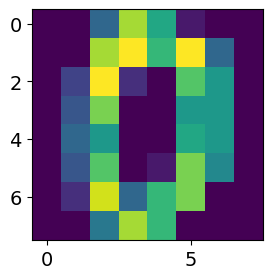

In [71]:
# GaussianNB
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
X = load_digits().data
y = load_digits().target
idx = 0
print("feature 확인: ", X[idx])
print("target 확인: ", y[idx])

X_train, X_test, y_train, y_test = train_test_split(X, y)
GNB = GaussianNB()
GNB.fit(X_train, y_train)
train_score = GNB.score(X_train, y_train)
test_score = GNB.score(X_test, y_test)
print("Train score {:.3f}, Test score {:.3f}".format(train_score, test_score))

#실제 숫자 이미지와 예측한 숫자 확인하기
pred = GNB.predict(X[idx].reshape(-1,len(X[idx])))
print("예측한 숫자: {} \n실제 숫자:".format(pred))
plt.rcParams['figure.figsize'] = (3,3)
plt.imshow(X[idx].reshape(8,8))
plt.show()

In [91]:
# spam mails [출처: https://www.kaggle.com/datasets/venky73/spam-mails-dataset]
from pandas import read_csv
emails = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/9-4_spam.csv').sample(300).reset_index(drop=True) #300개만 샘플링
print("원본 데이터: \n{}\n".format(emails.head(10)))

# dtm(document-term matrix)은 각 단어를 feature로, 문장 내 단어출현빈도를 값으로 가짐
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
Xv = cv.fit_transform(emails['email_title'])
dtm =DataFrame(Xv.toarray(), columns=cv.vocabulary_)
print("DTM: \n{}\n".format(dtm.iloc[:, 1050:1060].head(10)))

# 각 단어출현빈도를 feature로, spam 여부를 target으로 함
X = dtm
y = emails['spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

원본 데이터: 
                                         email_title  spam
0  Subject: bankruptcy management committee\r\nin...     0
1  Subject: fw : hpl imbalance payback\r\n- - - -...     0
2  Subject: fw : fw : conoco - big cowboy\r\nhere...     0
3  Subject: bridge back error\r\nmeter 980068 has...     0
4  Subject: re : new eol product\r\nthe texas gas...     0
5  Subject: re : equistar deal tickets\r\nhere is...     0
6  Subject: jump in to gain substantial ground im...     1
7  Subject: important online banking alert\r\ndea...     1
8  Subject: meter 1431 - nov 1999\r\naimee ,\r\ns...     0
9  Subject: guadalupe power partners - march 01 p...     0

DTM: 
   fraud  website  minutes  experience  renew  records  future  problems  \
0      0        0        0           0      0        0       0         0   
1      0        0        0           0      0        0       0         0   
2      0        0        0           0      0        0       0         0   
3      0        0        0     

In [94]:
# BernoulliNB
from sklearn.naive_bayes import BernoulliNB
BNB = BernoulliNB(binarize = 0) #예측변수가 이진변수가 아닌 경우 이진화하여 학습한다
BNB.fit(X_train, y_train)
train_score = BNB.score(X_train, y_train)
test_score = BNB.score(X_test, y_test)
print("Train score {:.3f}, Test score {:.3f}".format(train_score, test_score))

#실제 spam여부와 예측한 spam여부 확인하기
idx = 0
pred = BNB.predict(X.iloc[idx, :].values.reshape(-1, X.shape[1]))
print("예측한 spam여부: {}, 실제 spam여부: {}\n".format(pred, y[idx]))

# 각 class의 사전확률
print("각 class의 사전확률 False: {:.3f}, True: {:.3f}".format(BNB.class_log_prior_[0], BNB.class_log_prior_[1]))

# 각 feature의 각 class에 대한 사후확률 (각 클래스별 단어 중요도로도 볼 수 있음)
result = DataFrame(BNB.feature_log_prob_, columns=cv.vocabulary_, index=['False', 'True'])
print("각 feature의 각 class에 대한 사후확률: \n", result.iloc[:, 1000:1010])

# .feature_log_prob_는 각 class일 때 해당 feature인 단어가 나올 로그 확률을 의미한다. 
# 이 확률값이 높을수록, 해당 class일 때 해당 feature인 단어가 나올 확률이 높다는 의미이다. 
# 따라서, False에 대한 확률값이 낮을수록, True에 대한 확률값이 높을수록 spam일 확률이 높다.

Train score 0.796, Test score 0.827
예측한 spam여부: [0], 실제 spam여부: 0

각 class의 사전확률 False: -0.347, True: -1.226
각 feature의 각 class에 대한 사후확률: 
        familiar    poised  positioned      feel      come       act     trade  \
False -3.289645 -5.081404   -5.081404 -5.081404 -4.388257 -4.388257 -5.081404   
True  -4.219508 -3.526361   -3.526361 -3.526361 -4.219508 -4.219508 -3.526361   

        tuesday        go     penny  
False -4.388257 -5.081404 -5.081404  
True  -3.526361 -3.526361 -4.219508  


C:\Users\sunwa\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


In [96]:
# MultinomialNB
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
train_score = MNB.score(X_train, y_train)
test_score = MNB.score(X_test, y_test)
print("Train score {:.3f}, Test score {:.3f}".format(train_score, test_score))

#실제 spam여부와 예측한 spam여부 확인하기
idx = 0
pred = MNB.predict(X.iloc[idx, :].values.reshape(-1, X.shape[1]))
print("예측한 spam여부: {}, 실제 spam여부: {}\n".format(pred, y[idx]))

# 각 class의 사전확률
print("각 class의 사전확률 False: {:.3f}, True: {:.3f}".format(MNB.class_log_prior_[0], MNB.class_log_prior_[1]))

# 각 feature의 각 class에 대한 사후확률 (각 클래스별 단어 중요도로도 볼 수 있음)
result = DataFrame(MNB.feature_log_prob_, columns=cv.vocabulary_, index=['False', 'True'])
print("각 feature의 각 class에 대한 사후확률: \n", result.iloc[:, 2000:2010])

Train score 0.991, Test score 0.973
예측한 spam여부: [0], 실제 spam여부: 0

각 class의 사전확률 False: -0.347, True: -1.226
각 feature의 각 class에 대한 사후확률: 
             bill   allowed    makeup     toward  purchased  tolerance  \
False -10.414693 -9.721546 -9.316081 -10.414693 -10.414693 -10.414693   
True   -7.946213 -9.892123 -9.892123  -8.793511  -9.892123  -9.892123   

        kimberly     vaughn      2256       7214  
False -10.414693 -10.414693 -5.723345 -10.414693  
True   -9.198976  -9.892123 -8.793511  -9.892123  


C:\Users\sunwa\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


### **9-5. 인공신경망**
- 목적/손실 함수, 최적화, 정규화 방법 등 정의 필요
- 주로 Tensorflow와 Pytorch 라이브러리 활용
- 텐서플로우 모델 구현 순서: 모델 구축 -> 구조확인 -> 컴파일 -> 학습 -> 평가 -> 예측
- 텐서플로우 주요 파라미터
  1) activation: 활성화 함수 (relu, sigmoid, softmax 등)
  2) kernel_regularizer : 정규화 방법 (L1, L2 등)
  3) loss, optimizer, metrics, batch_size, epochs (학습 횟수) 등

#### 다층 퍼셉트론 (MLP)
- 딥러닝 알고리즘의 출발점. 비교적 간단하게 분류와 회귀에 사용
- MLP 학습 1단계 (전향): 입력과 가중치 값을 통해서 출력값 계산  
  MLP 학습 2단계 (후향): 출력과 목표 값 차이에 대해서 가중치 갱신 --> 오차 역전파
- 장점: 대량 데이터 작동, 매우 복잡한 모델, 좋은 성능  
  단점: 학습이 오래 걸림, 스케일링 등 전처리 필요

전체 클래스:  [0 1 2 3 4 5 6 7 8 9]
클래스별 데이터 수:  [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


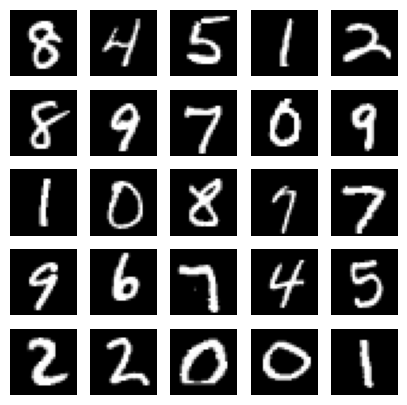

[[8 4 5 1 2]
 [8 9 7 0 9]
 [1 0 8 7 7]
 [9 6 7 4 5]
 [2 2 0 0 1]]
(28, 28)


In [1]:
# Tensorflow에서 MNIST 데이터 불러오기
import numpy as np
from tensorflow.keras.datasets.mnist import load_data
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

(x_train, y_train), (x_test, y_test) = load_data(path='mnist.npz')

# 트레인셋의 unique들(타겟값들, 클래스들)과 그 개수 확인 
unique, counts = np.unique(y_train, return_counts = True)
print("전체 클래스: ", unique)
print("클래스별 데이터 수: ", counts)

# 훈련 데이터세트에서 25개의 숫자 샘플 추출하기
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]

# 25개의 샘플 숫자 확인하기
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    image = images[i] # image = 28*28픽셀의 숫자 매트릭스 (각 숫자는 0~255)
    plt.subplot(5,5, i+1) #subplot(가로, 세로, 순서)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()
print(labels.reshape(-1,5))
print(image.shape)

변환 전 타겟변수:  5
변환 후 타겟변수:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
X 데이터 형태 변환:  (10000, 28, 28)  ->  (10000, 784)


C:\Users\sunwa\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 269,322 (1.03 MB)

 Trainable params: 269,322 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

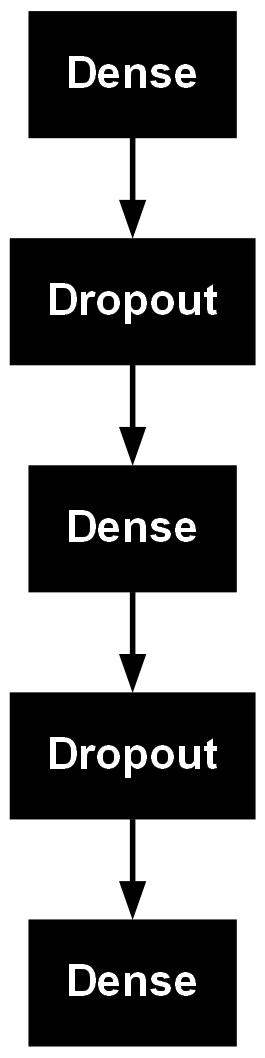

In [2]:
# Tensorflow로 MLP 구축하기
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2, l1

## 모델 구축을 위한 데이터 전처리

# 타겟변수를 0~9의 희박한 스칼라로 표현하는 것은 클래스별 확률을 출력하는 
# 신경망 예측 계층에 적합하지 않기 때문에 이를 원핫벡터로 변환한다. (0~9 숫자를 각각 1x10 행렬로 변환)
y_train2 = to_categorical(y_train)
y_test2 = to_categorical(y_test)
print("변환 전 타겟변수: ", y_train[0])
print("변환 후 타겟변수: ", y_train2[0])

# 이미지 차원 (정사각형으로 가정)
image_size = x_train.shape[1] #데이터의 픽셀값들 (28, 28) 
input_size = image_size * image_size

# X는 shape 변환 (28*28를 1*784) 및 변수 스케일링
x_train2 = x_train.reshape(-1, input_size)
x_test2 = x_test.reshape(-1, input_size)
print("X 데이터 형태 변환: ", x_test.shape," -> ", x_test2.shape)

# 각 픽셀값을 0~255 범위에서 0.0~1.0 범위의 값으로 척도를 변경한다. 원본 픽셀값을 직접 사용할 수도 있지만 
# 그렇게 되면 편향 값이 커져서 모델 훈련이 어려워지므로 입력 데이터를 정규화하는 것이 좋다. 
# 그에 따라 신경망의 출력도 정규화되지만, 훈련이 끝나면 출력 텐서에 255를 곱해서 정수 픽셀값으로 모두 되돌릴 수 있다.
x_train2 = x_train2.astype('float32') / 255
x_test2 = x_test2.astype('float32') / 255


## 모델 구축
input_shape = input_size
batch_size = 128
epochs = 10
hidden_units = 256
dropout = 0.45

# 3개의 계층으로 이루어진 MLP에 정규화 요소, 일반화 요소, 활성화 함수를 적용.
model = Sequential()
model.add(Dense(hidden_units, input_dim=input_shape, kernel_regularizer=l2(0.001)))
model.add(Dropout(dropout))
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(y_train2.shape[1], activation='softmax'))
model.summary()

plot_model(model)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7786 - loss: 0.9334 - val_accuracy: 0.9409 - val_loss: 0.3382
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9167 - loss: 0.4053 - val_accuracy: 0.9540 - val_loss: 0.2558
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9309 - loss: 0.3269 - val_accuracy: 0.9601 - val_loss: 0.2128
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9344 - loss: 0.2961 - val_accuracy: 0.9605 - val_loss: 0.1969
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9394 - loss: 0.2763 - val_accuracy: 0.9669 - val_loss: 0.1787
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9408 - loss: 0.2691 - val_accuracy: 0.9683 - val_loss: 0.1707
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9435 - loss: 0.2487 - val_accuracy: 0.9734 - val_loss: 0.1608
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9456 - loss: 0.2485 - val_accuracy: 0.

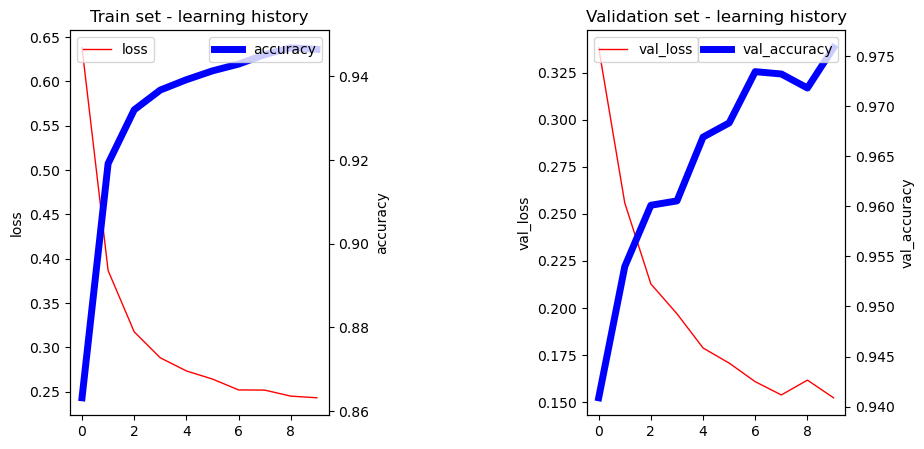


테스트 셋의 loss 0.168, accuracy 0.972

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
예측값:  [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
실제값:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


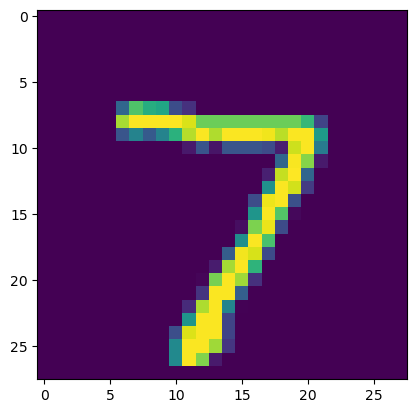

In [3]:
# 모델 컴파일
model.compile(loss=['categorical_crossentropy'], metrics=['accuracy'], optimizer='adam')

# 모델 학습
fitted = model.fit(x_train2, y_train2, validation_data= (x_train2, y_train2,), epochs=epochs, batch_size= batch_size)

# 학습 히스토리 확인
from pandas import DataFrame
result=DataFrame(fitted.history)
print("\n학습 히스토리:\n", result.tail(3))

# 학습 히스토리 시각화
plt.rcParams["font.size"] = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=1)

ax11 = ax1.twinx()

ax1.plot(result['loss'], color='red', label='loss', linewidth=1)
ax1.legend(loc='upper left')
ax1.set_ylabel("loss")

ax11.plot(result['accuracy'], color='blue', label='accuracy', linewidth=5)
ax11.legend(loc='upper right')
ax11.set_ylabel("accuracy")
plt.title("Train set - learning history")

ax22 = ax2.twinx()

ax2.plot(result['val_loss'], color='red', label='val_loss', linewidth=1)
ax2.legend(loc='upper left')
ax2.set_ylabel("val_loss")

ax22.plot(result['val_accuracy'], color='blue', label='val_accuracy', linewidth=5)
ax22.legend(loc='upper right')
ax22.set_ylabel("val_accuracy")
plt.title("Validation set - learning history")
plt.show()

# 모델 평가
loss, acc = model.evaluate(x_test2, y_test2, batch_size=batch_size, verbose=False)
print("\n테스트 셋의 loss {:.3f}, accuracy {:.3f}\n".format(loss, acc))

# 모델 예측
j = 0
pred = model.predict(np.reshape(x_test2[j], (-1, input_shape)))
pred.flatten() 
print("예측값: ", pred.round(1))
print("실제값: ", y_test2[j])
plt.imshow(x_test2[j].reshape(-1,image_size))
plt.show()

#### 연습문제 #1

In [2]:
import pandas as pd
realestate = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice8_BHP2.csv')
print(realestate)

     area_type  availability  size  total_sqft  bath  balcony   price
0        Super             0     3      1056.0     2        1   39.07
1         Plot             1     6      2600.0     5        3  120.00
2        Super             1     5      1521.0     3        1   95.00
3        Super             1     3      1170.0     2        1   38.00
4         Plot             1     6      2785.0     5        3  295.00
...        ...           ...   ...         ...   ...      ...     ...
7490     Super             1     5      1345.0     2        1   57.00
7491     Super             1     5      1715.0     3        3  112.00
7492  Built-up             1     8      3453.0     4        0  231.00
7493  Built-up             1     3      1141.0     2        1   60.00
7494     Super             0     7      4689.0     4        1  488.00

[7495 rows x 7 columns]


In [3]:
# KNN, SVM, 랜덤포레스트 알고리즘으로 회귀 모델을 생성하려고 한다. 먼저, 데이터 전처리로 원핫인코딩과 데이터 표준화를 진행하였다.
from pandas import get_dummies, DataFrame
df = get_dummies(realestate, columns=['area_type'])
X = df.drop('price', axis=1) 
y = df['price']

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_X = DataFrame(ss.fit_transform(X), columns=X.columns)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y)

In [4]:
# 1. KNN은 이해하기 쉽고, 파라미터 조정을 많이 하지 않아도 좋은 성능을 내는 장점을 가지고 있다. 
# 다만, 데이터 전처리가 중요하고, 특성이 너무 많으면 잘 작동하지 않는다.
from sklearn.neighbors import KNeighborsRegressor
knnr = KNeighborsRegressor(n_neighbors=4, weights='distance', p=2)
knnr.fit(X_train, y_train)
train_score = knnr.score(X_train, y_train)
test_score = knnr.score(X_test, y_test)
print("train score {:.3f}, test score {:.3f}".format(train_score, test_score))

train score 0.985, test score 0.555


In [5]:
# 2. SVM은 데이터의 특성이 몇개 안되더라도 복잡한 결정경계를 만들 수 있고 저차원과 고차원 데이터에서 모두 잘 동작한다. 
# 반면, 대용량 데이터에서는 잘 작동하지 않고 데이터 전처리와 파라미터 조정이 중요하다.
from sklearn.svm import SVR
reg = SVR(C=50, epsilon=0.5)
reg.fit(X_train, y_train)
train_score = reg.score(X_train, y_train)
test_score = reg.score(X_test, y_test)
print("train score: {:.3f}, test score: {:.3f}".format(train_score, test_score))

train score: 0.549, test score: 0.660


In [6]:
# 3. 랜덤포레스트는 트리들을 병렬로 학습할 수 있어 계산 비용이 효율적이고, 
# 매개변수 조정을 많이 하지 않아도 잘 동작하며 데이터의 스케일에서 자유롭다. 
# 반면, 직관적인 해석은 불가능하다는 단점이 있다.
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=6)
rf.fit(X_train, y_train)
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)
print("train score: {:.3f}, test score: {:.3f}".format(train_score, test_score))
## test score(결정계수) 기준으로 KNN 모델의 성능이 가장 높은 것으로 나왔다.

train score: 0.835, test score: 0.706


#### 연습문제 #2

In [7]:
MED = realestate['price'].median()
realestate['level'] = realestate['price'].apply(lambda x: 1 if x>=MED else 0)
print(realestate)

     area_type  availability  size  total_sqft  bath  balcony   price  level
0        Super             0     3      1056.0     2        1   39.07      0
1         Plot             1     6      2600.0     5        3  120.00      1
2        Super             1     5      1521.0     3        1   95.00      1
3        Super             1     3      1170.0     2        1   38.00      0
4         Plot             1     6      2785.0     5        3  295.00      1
...        ...           ...   ...         ...   ...      ...     ...    ...
7490     Super             1     5      1345.0     2        1   57.00      0
7491     Super             1     5      1715.0     3        3  112.00      1
7492  Built-up             1     8      3453.0     4        0  231.00      1
7493  Built-up             1     3      1141.0     2        1   60.00      0
7494     Super             0     7      4689.0     4        1  488.00      1

[7495 rows x 8 columns]


#### 연습문제 #3

In [9]:
# 로지스틱 회귀와 랜덤 포레스트로 분류 모델을 생성하려고 한다. 
# 1. 랜덤포레스트는 트리들을 병렬로 학습할 수 있어 계산 비용이 효율적이고, 
# 매개변수 조정을 많이 하지 않아도 잘 동작하며 데이터의 스케일에서 자유롭다. 
# 반면, 직관적인 해석은 불가능하다.
from sklearn.model_selection import train_test_split
bi_y = realestate['level']
X_train, X_test, y_train, y_test = train_test_split(scaled_X, bi_y, stratify=bi_y)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=6)
rf.fit(X_train, y_train)
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)
print("train score: {:.3f}, test score: {:.3f}".format(train_score, test_score))

train score: 0.853, test score: 0.843


In [10]:
# 2. 로지스틱 회귀는 재계산 없이 새로운 데이터에 대한 결과를 빠르게 계산할 수 있고, 
# 다른 분류 방법들에 비해 모델을 해석하기가 쉽다는 장점이 있다. 
# 단, 회귀계수의 왜곡을 피하기 위해 데이터 스케일에 대한 전처리가 필요하다. 

from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=1, max_iter=1000)
LR.fit(X_train, y_train)
train_score = LR.score(X_train, y_train)
test_score = LR.score(X_test, y_test)
print("train score: {:.3f}, test score: {:.3f}".format(train_score, test_score))

# test score(accuracy) 기준으로 랜덤포레스트의 성능이 다소 앞서는 것을 확인하였다.

train score: 0.832, test score: 0.829


#### 연습문제 #4

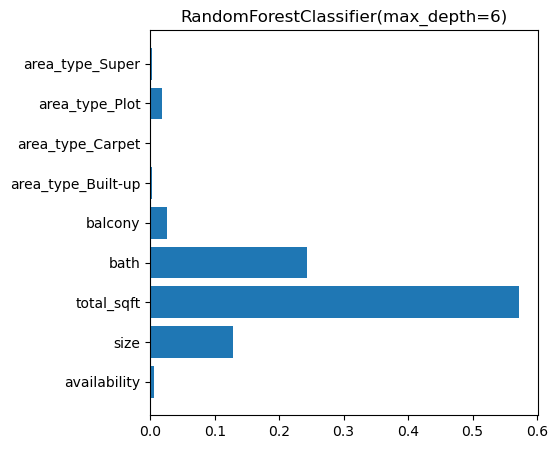

In [14]:
# 1. 랜덤 포레스트 모델: feature importance 비교
# total_sqft, bath, size, balcony 순으로 트리 생성에 가장 많이 기여한 변수
import matplotlib.pyplot as plt
fi = rf.feature_importances_
fn = X.columns
fig, ax = plt.subplots(figsize=(5,5))
plt.title(rf)
plt.barh(fn, fi)
plt.show()

## 이를 미루어볼 때 total_sqft, size, bath 변수가 중요한 것으로 생각된다.

In [12]:
# 2. 로지스틱 회귀모델: 회귀계수들의 절대값 비교 
# total_sqft, area_type_Plot, size, bath 순으로 영향력이 높은 변수로 확인
import numpy as np
lr_coef = DataFrame({'feat':X.columns, 'coef':LR.coef_.ravel()})
lr_coef['abs'] = lr_coef['coef'].apply(lambda x: np.abs(x))
print(lr_coef.sort_values(by='abs', ascending=False))

                 feat      coef       abs
2          total_sqft  6.797787  6.797787
7      area_type_Plot  0.587647  0.587647
1                size -0.559937  0.559937
3                bath  0.365298  0.365298
8     area_type_Super -0.184324  0.184324
0        availability -0.177425  0.177425
5  area_type_Built-up -0.105722  0.105722
4             balcony -0.074404  0.074404
6    area_type_Carpet  0.029320  0.029320
